### TODO: 
- Add rolling window example 

Taking a crack at this: [Rossman store sales](https://www.kaggle.com/c/rossmann-store-sales/data)

# What are we up to here? 

We were given some data from a retailer, with all of their stores, and info about their clients and sales for each day. 

With this dataset, we want to create an estimator that can forecast sales on the next day. 

In [9]:
import pandas as pd 

# visualization stuff: 
import seaborn as sns
from matplotlib import pyplot as plt 
% matplotlib inline 

# A few optional things to get rid of useless warnings, and to make plots pretty
import warnings 
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('seaborn')

In [10]:
# Let's get our dataset: 
train = pd.read_csv('../data/sales_data.csv', 
                    low_memory=False)  # this is used to ensure that it checks the types properly 
train.head(3)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
0,2013-01-01,1115,2,0,0,0,0,a,1,1,0,0,1
1,2013-01-01,378,2,0,0,0,0,a,1,1,0,0,1
2,2013-01-01,375,2,0,0,0,0,a,1,1,0,0,1


What types of object do we have? 

In [11]:
train.dtypes

Date                         object
Store                         int64
DayOfWeek                     int64
Sales                         int64
Customers                     int64
Open                          int64
Promo                         int64
StateHoliday                 object
SchoolHoliday                 int64
Next day is SchoolHoliday     int64
Next day is StateHoliday     object
Next day is a Promo           int64
Next day is Open              int64
dtype: object

We know this is a timeseries problem, so let's look at this `Date` index: 

In [12]:
train.Date.head()

0    2013-01-01
1    2013-01-01
2    2013-01-01
3    2013-01-01
4    2013-01-01
Name: Date, dtype: object

It's an object (bunch of strings). Pandas has lots of useful functionality to deal with timeseries, so let's turn these days into timeseries objects. We will use the [to_datetime](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) command.  

It can infer the format, but in general it is always a good idea to be explicit about the format. In this case we can see that our dates are Year-month-day (`format=%Y-%m-%d`)

In [13]:
train['Date'] = pd.to_datetime(train['Date'],       # we want the Date column to be a date 
                               format='%Y-%m-%d')   # the date format helps Pandas not have to infer it 

Now we can make it our index, and then sort the dataframe on the date: 

In [14]:
train.set_index(['Date', 'Store'],     # A multi-index, as we care about both companies and dates
                inplace=True)          # Set the index in place 
train.sort_index(inplace=True)         # sort the dataset on the index 

In [33]:
train.head(5)

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 1              2      0          0     0      0            a   
           2              2      0          0     0      0            a   
           3              2      0          0     0      0            a   
           4              2      0          0     0      0            a   
           6              2      0          0     0      0            a   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-01 1                  1                          1   
           2                  1                          1   
           3                  1                          1   
           4                  1                          1   
           6                  1                          1   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-01 1                            0                    0   
           2                            0                    0   
           3                            0                    0   
           4                            0                    0   
           6                            0                    0   

                  Next day is Open  
Date       Store                    
2013-01-01 1                     1  
           2                     1  
           3                     1  
           4                     1  
           6                     1

So what is going on here? We have a [multiindex](https://stackoverflow.com/questions/13226029/benefits-of-pandas-multiindex). In other words, we both depend on Date, and on Time. 

# Stores

We have a couple of things going on here. We have time, but we also have stores. We will try to, based on the previous day Sales of that Store, predict the sales of the next day. 

This is far from trivial, as we will explore. 

But, for now, let's observe a single store through time. Let's take that first store, #1115. Selecting in multi-indexes requires a new command, [xs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.xs.html)

In [38]:
train.xs(1115,              # <-- the store number 
         level='Store',     # <-- The level of the index 
         drop_level=True    # <-- Whether we want to keep the store in the index (would just be 1115 over and over)
        ).head(7)           # <-- show the first 7 lines     

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Next day is SchoolHoliday,Next day is StateHoliday,Next day is a Promo,Next day is Open
Date,,,,,,,,,,,
2013-01-01,2,0,0,0,0,a,1,1,0,0,1
2013-01-02,3,3697,305,1,0,0,1,1,0,0,1
2013-01-03,4,4297,300,1,0,0,1,1,0,0,1
2013-01-04,5,4540,326,1,0,0,1,1,0,0,1
2013-01-05,6,4771,339,1,0,0,1,1,0,0,0
2013-01-06,7,0,0,0,0,0,1,1,0,1,1
2013-01-07,1,6905,471,1,1,0,1,1,0,1,1


Let's keep this store in a variable, so that we can call it easily (remember, this does not make a copy) 

In [39]:
store_1115 = train.xs(1115, level='Store')

This way we're looking at a particular Store. Cool.  What do the sales of our Store look like? 

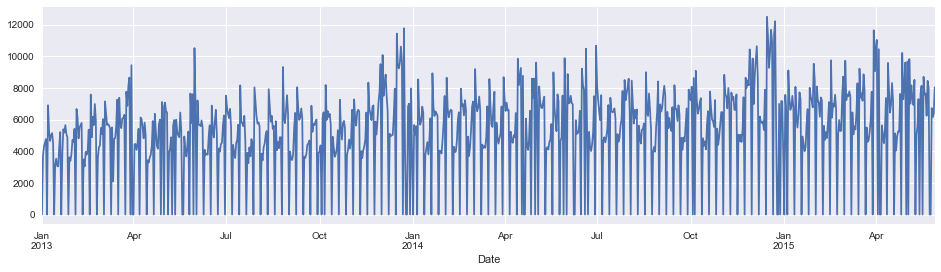

In [103]:
store_1115['Sales'].plot(figsize=(16, 4))   # <-- plot it 

Uau... that's kind of useless. 

The problem here is that we have a very strong effect of the day of the week, holidays, etc, so the signal is completely lost. 

One way to deal with this would be to use the [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) capability. Let's resample this to the week, and see what happens: 

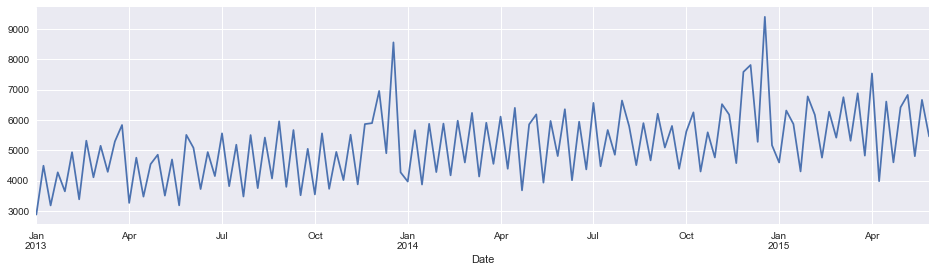

In [138]:
weekly_resampled_mean = store_1115['Sales'].resample('w').mean()  # <-- resample to weekly, then take the mean 

weekly_resampled_mean.plot(figsize=(16, 4))   # <-- plot it 

If we want, we can also do a rolling window at this point: 

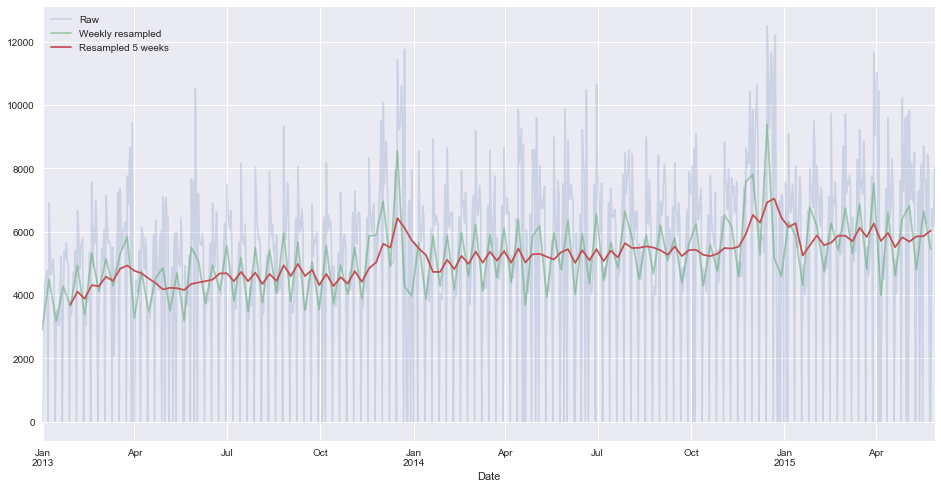

In [150]:
store_1115['Sales'].plot(figsize=(16, 8), label='Raw', alpha=.2)   # <-- plot it 
weekly_resampled_mean.plot(label='Weekly resampled', alpha=.5)
weekly_resampled_mean.rolling(5).mean().plot(label='Resampled 5 weeks')   
plt.legend()
plt.show()

How does the day of the week affect this? 

In [53]:
store_1115[['DayOfWeek', 'Open', 'Sales']].head(10)

,DayOfWeek,Open,Sales
Date,,,
2013-01-01,2,0,0
2013-01-02,3,1,3697
2013-01-03,4,1,4297
2013-01-04,5,1,4540
2013-01-05,6,1,4771
2013-01-06,7,0,0
2013-01-07,1,1,6905
2013-01-08,2,1,5243
2013-01-09,3,1,4649


Hmm... not very useful. Let's try to take the mean per day of the week, then plot it: 

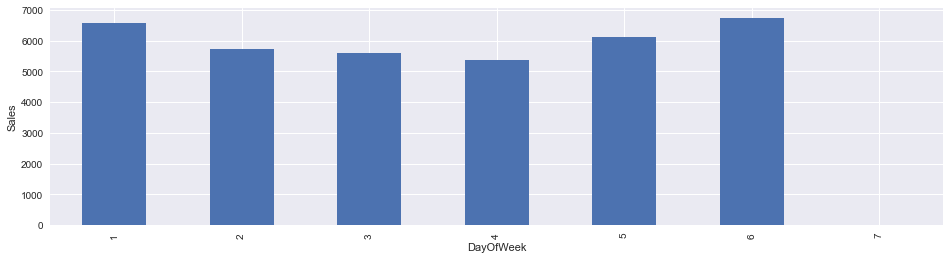

In [57]:
# mean sales = our store grouped by day of the week, and aggregating by the mean 
mean_sales_grouped_by_day_of_week = store_1115.groupby('DayOfWeek')['Sales'].mean()

mean_sales_grouped_by_day_of_week.plot(kind='bar', figsize=(16, 4))
plt.ylabel('Sales')

So there are no sales on day 7 (Sunday?) and day 1 and 6 are the best ones. 

Maybe we can break the plot into the different days of the week? 

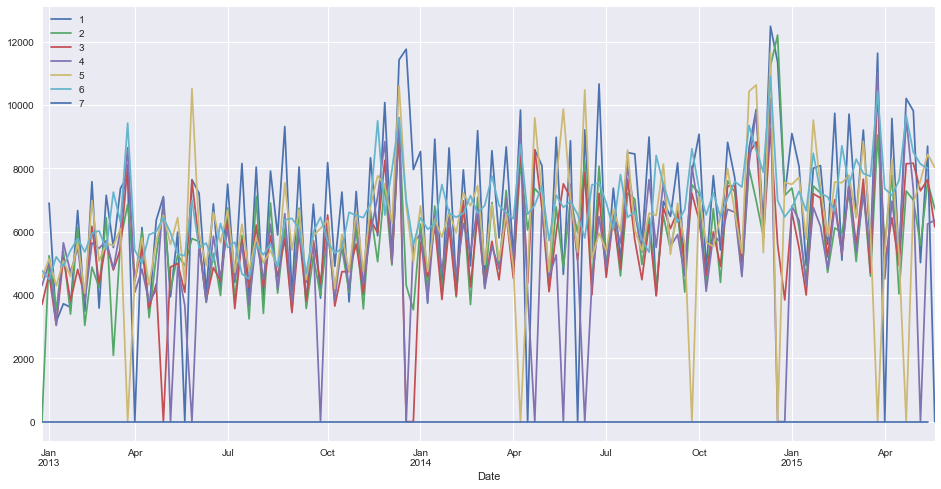

In [112]:
store_1115.groupby('DayOfWeek')['Sales'].plot(figsize=(16, 8))
plt.legend()
plt.show()

Hmm... This isn't very legible, maybe we can make a rolling window? 

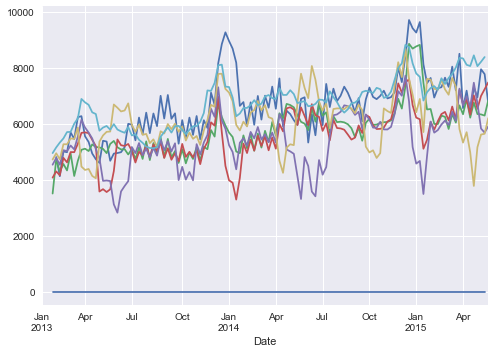

In [132]:
for key, grp in store_1115.groupby('DayOfWeek'):
    grp['Sales'].rolling(5).mean().plot()

Maybe it would be interesting to get the mean per month? 

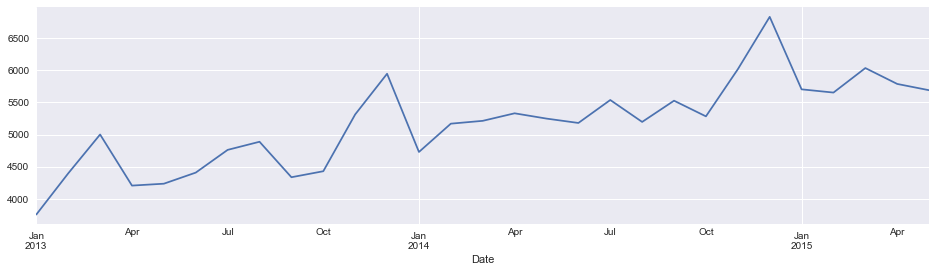

In [59]:
monthly_resampled_mean = store_1115['Sales'].resample('m').mean()  # <-- resample to weekly, then take the mean 

monthly_resampled_mean.plot(figsize=(16, 4))   # <-- plot it 

Relatively clear trend, and it seems to be quite dependent on the month. 

#### How many stores do we have? 

In [72]:
train.head(3)

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 1              2      0          0     0      0            a   
           2              2      0          0     0      0            a   
           3              2      0          0     0      0            a   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-01 1                  1                          1   
           2                  1                          1   
           3                  1                          1   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-01 1                            0                    0   
           2                            0                    0   
           3                            0                    0   

                  Next day is Open  
Date       Store                    
2013-01-01 1                     1  
           2                     1  
           3                     1

We want to predict stores, so it is quite relevant to know how many we have. 


Now, if we wanted to know how many Days of the week we have, we could use [nunique](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.nunique.html). 

Will this also work with `Stores`, which is part of the index? 

In [73]:
train.DayOfWeek.nunique()

7

In [78]:
try: 
    train.Store.nunique()
except Exception as e:
    print('Oh no! We had an exception: \n%s' % e)

Oh no! We had an exception: 
'DataFrame' object has no attribute 'Store'


Oh, right, it's on the index. 

This is the proper way to get it: 

In [92]:
train.head(2)

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 1              2      0          0     0      0            a   
           2              2      0          0     0      0            a   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-01 1                  1                          1   
           2                  1                          1   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-01 1                            0                    0   
           2                            0                    0   

                  Next day is Open  
Date       Store                    
2013-01-01 1                     1  
           2                     1

In [91]:
stores_level_of_the_index = train.index.levels[1]
len(stores_level_of_the_index)

558

And this is the lazy way to do this: 

In [81]:
train.reset_index()['Store'].nunique()

558

Lots of stores. Fun! 

We also know that we have some days on which some stores are not open: 

In [83]:
train.head(3)

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 1              2      0          0     0      0            a   
           2              2      0          0     0      0            a   
           3              2      0          0     0      0            a   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-01 1                  1                          1   
           2                  1                          1   
           3                  1                          1   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-01 1                            0                    0   
           2                            0                    0   
           3                            0                    0   

                  Next day is Open  
Date       Store                    
2013-01-01 1                     1  
           2                     1  
           3                     1

#### Do stores that have open == 0 ever sell anything?

In [84]:
train.groupby('Open')['Sales'].mean()

Open
0       0.000000
1    6947.130384
Name: Sales, dtype: float64

No, and that makes sense. Let's get a subset of open stores to observe then. 

In [85]:
train_open = train[train['Open']==1]   

In [86]:
train_open.head()

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 259            2   6851       1444     1      0            a   
           274            2   3102        729     1      0            a   
           494            2   3113        527     1      0            a   
           530            2   2907        532     1      0            a   
           682            2   3375        566     1      0            a   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2013-01-01 259                1                          1   
           274                1                          1   
           494                1                          1   
           530                1                          1   
           682                1                          1   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2013-01-01 259                          0                    0   
           274                          0                    0   
           494                          0                    0   
           530                          0                    0   
           682                          0                    0   

                  Next day is Open  
Date       Store                    
2013-01-01 259                   1  
           274                   1  
           494                   1  
           530                   1  
           682                   1

How many clients visit these stores, on open days? 

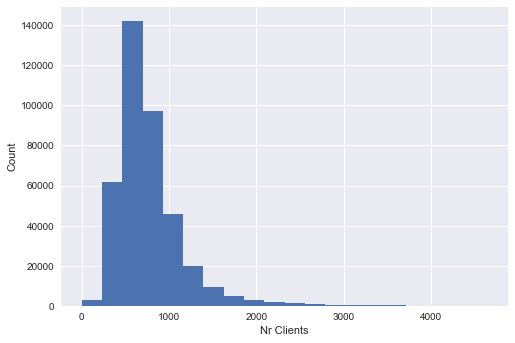

In [87]:
train_open.Customers.hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Nr Clients')

Actually, this isn't very useful. We're seeing the same store on lots of days, and lots of stores, which is completely not intuitive.  

What we want to know is: per store, what is the median number of clients, and then get a distribution of that.

We could do it this way... 

CPU times: user 1.22 s, sys: 11 ms, total: 1.23 s
Wall time: 1.26 s


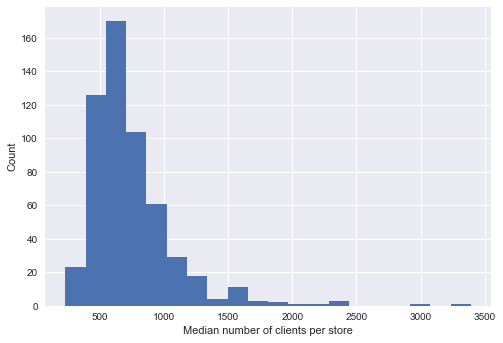

In [95]:
%%time
# Using %%time is cool! Prints the time that the cell takes to run
median_clients = {}  # <-- don't actually do this, it's just to exemplify
for store in train_open.index.levels[1].unique():  
    median_clients[store] = train_open.xs(store, level='Store'    # <-- remember this xs thing? 
                                         )['Customers'].median()  # <-- getting the median of the number of clients
    
pd.Series(median_clients).hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Median number of clients per store')

Or, in a more pandas way, we can do this with a [groupby](https://pandas.pydata.org/pandas-docs/stable/groupby.html). 

_(Also, notice the speedup we get!)_

CPU times: user 87.4 ms, sys: 6.39 ms, total: 93.8 ms
Wall time: 92.7 ms


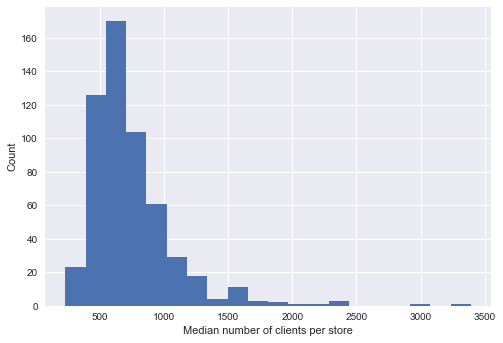

In [99]:
%%time
train_open.groupby(level='Store')['Customers'].median().hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Median number of clients per store')

Now, you probably notice that we wrote `data.groupby(level='Store')`instead of `data.groupby('Store')`.   
That's because Store is part of the index!

Same question for sales, what is the distribution of median sales, per store?

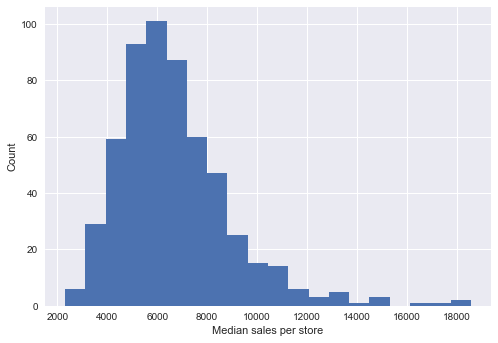

In [100]:
train_open.groupby(level='Store')['Sales'].median().hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Median sales per store')

Obvious question: how does the number of clients correlate with sales?

In [101]:
train_open.Sales.corr(train_open.Customers)

0.80724546863151514

Can we visualize this?

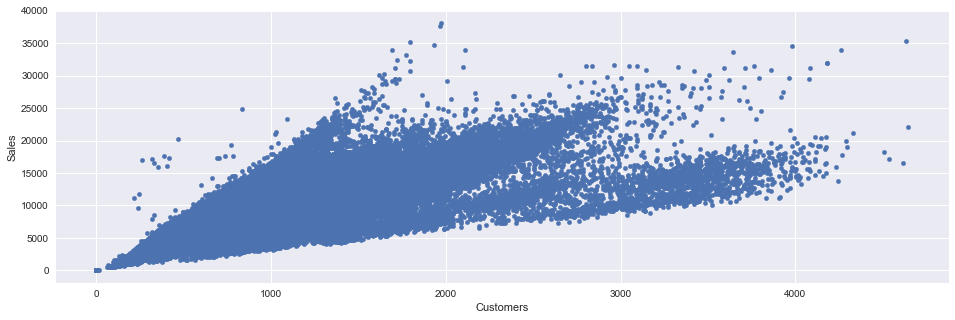

In [102]:
train_open.plot(kind='scatter',
                x='Customers',                
                y='Sales', 
               figsize=(16, 5))   # warning: this cell takes a while to run 

Interesting, if somewhat unclear. There seem to be multiple groups, but there are so many points that it is hard to tell. 

Let's [break the number of customers into bins](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html), to be able to calculate some medians

In [113]:
train_open['Customers_binned'] = pd.cut(train_open.Customers, bins=20)

What does this look like? 

In [114]:
train_open[['Customers', 'Customers_binned']].head()

,Customers,Customers_binned
Date,,
2013-01-01,527,"(464.5, 696.75]"
2013-01-01,532,"(464.5, 696.75]"
2013-01-01,729,"(696.75, 929.0]"
2013-01-01,1444,"(1393.5, 1625.75]"
2013-01-01,1039,"(929.0, 1161.25]"


It turned it into a discrete space. Now we can actually group by this `Customers_binned`, and see the median sales: 

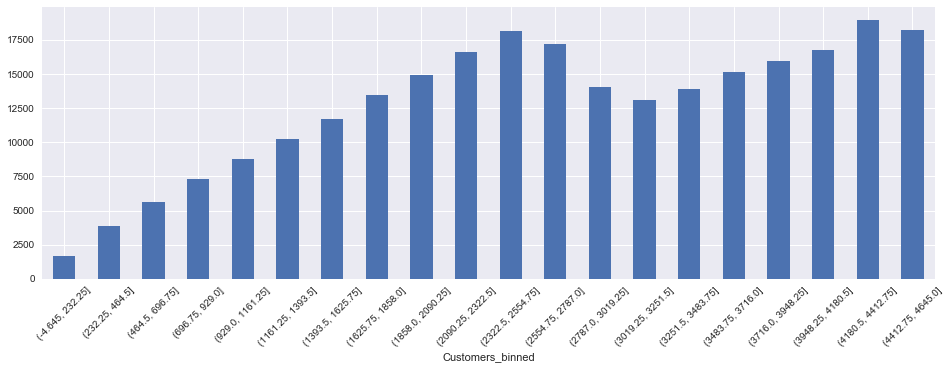

In [150]:
train_open.groupby('Customers_binned')['Sales'].median().plot(kind='bar', rot=45, figsize=(16, 5))

Very interesting, clearly this is linear to a point, and then changes. 

Theories: 
- Maybe they have other stores that have different pricing policies? 
- Maybe they open on different days of the week? 

Let's overlay the previous plot, with one showong how many stores are actually in each bin: 

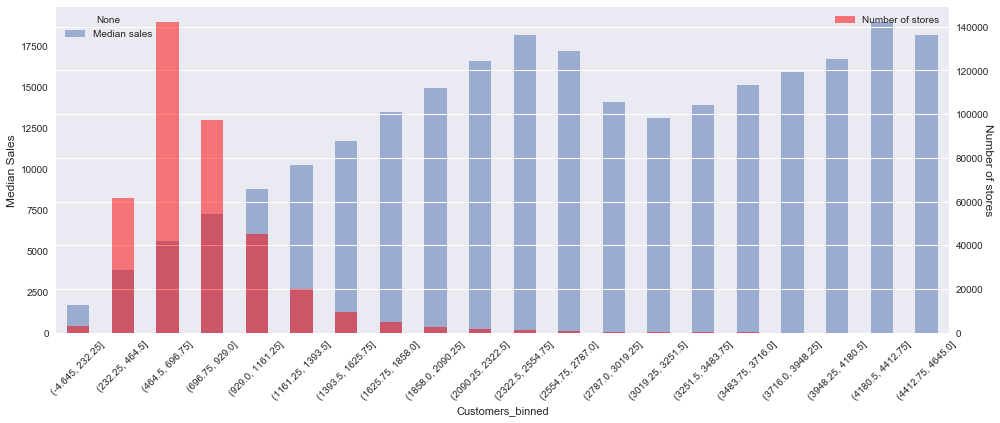

In [193]:
train_open.groupby('Customers_binned')['Sales'].median().plot(kind='bar', 
                                                              rot=45, 
                                                              alpha=.5, 
                                                              figsize=(16, 6),
                                                              label='Median sales')
plt.legend()
plt.ylabel('Median Sales', fontsize=12);

train_open.groupby('Customers_binned')['Sales'].count().plot(kind='bar', 
                                                             rot=45, 
                                                             alpha=.5,
                                                             color='r', 
                                                             label='Number of stores', 
                                                             secondary_y=True)
plt.legend()
plt.ylabel('Number of stores', fontsize=12, rotation=-90)

plt.show()

Interesting, so in reality almost all stores are in the linear relationship space, and the ones that aren't are in a long tail. 

We'd never have noticed this by looking at only one chart! 

#### How does DayOfWeek affect sales? 

Here, we will use a [seaborn boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

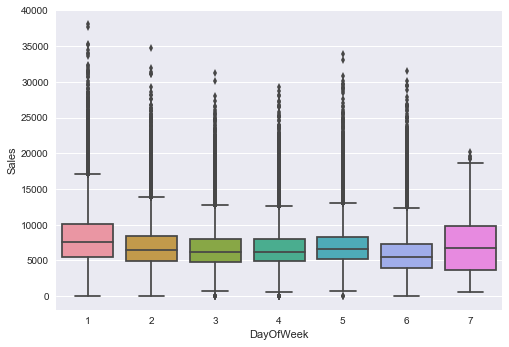

In [194]:
sns.boxplot(x=train_open['DayOfWeek'], 
            y=train_open['Sales'])

We have a bias here: we are looking into the open stores only, and it looks as though some stores might be open on Sundays. What would happen if we were looking at the full dataset? 

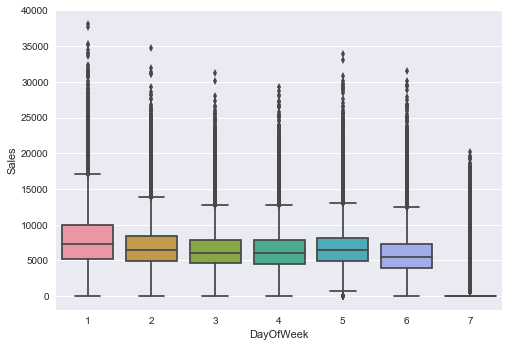

In [195]:
sns.boxplot(x=train['DayOfWeek'], 
            y=train['Sales'])  # using train instead of train_open

Interesting, it would seem that the stores that are open on Sundays have different behaviours. 

#### There seemed to be a promotions column. Do promotions work?

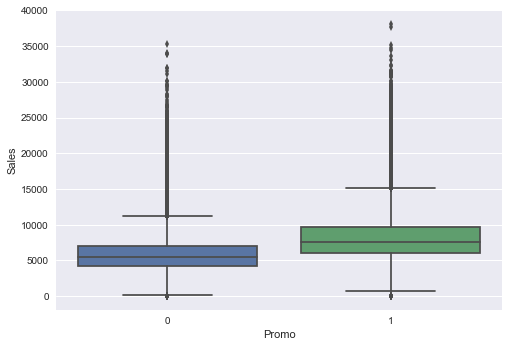

In [22]:
sns.boxplot(x=train_open['Promo'],
            y=train_open['Sales'])

Maybe... but we should be skeptical. Maybe promotions are done on days of the week, which might sell more anyway? Let's see how the boxplot of day of the week looks like, controlling for promotion:

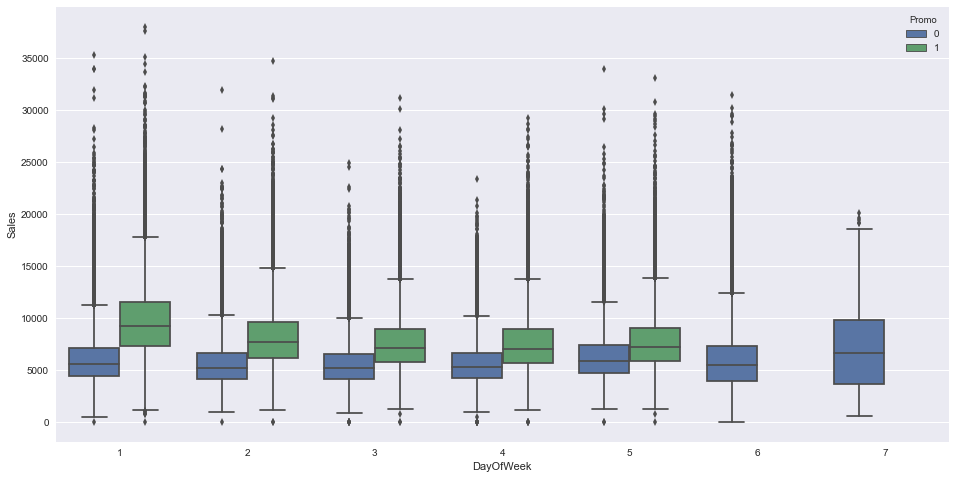

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x=train_open['DayOfWeek'], 
            y=train_open['Sales'], 
            hue=train_open['Promo'])   # the hue (color) will indicate if there was a promotion

Looks like promotions work, especially on Mondays. 

How about state Holidays? 

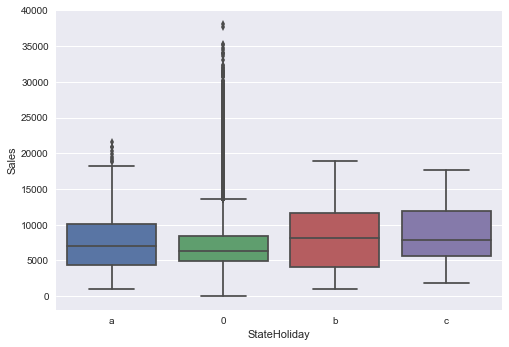

In [24]:
sns.boxplot(x=train_open['StateHoliday'], 
            y=train_open['Sales'])

Interestingly, it is categorical, and the box plots dealt with that very nicely. 

School holiday? 

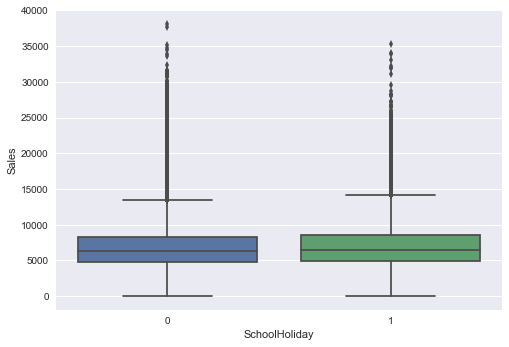

In [25]:
sns.boxplot(x=train_open['SchoolHoliday'], y=train_open['Sales'])
plt.show()

Excellent. Now we have an idea of what the data looks like, let's look at a few things from a timeseries point of view. 

# Timeseries analysis

Let's [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) the date to monthly 

In [26]:
monthly = train.resample('m')  # 'm' is monthly 

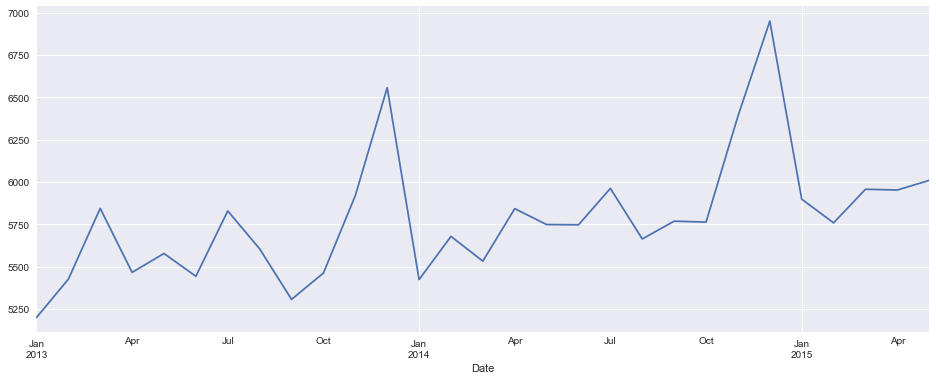

In [27]:
monthly.Sales.median().plot(figsize=(16, 6))

How does the month affect these results? We'll have to [create the month from the timeseries index](https://www.google.pt/search?q=pandas+month&oq=pandas+month+&aqs=chrome..69i57j69i60l5.1313j0j7&sourceid=chrome&ie=UTF-8)

In [196]:
train_open['Month'] = train_open.index.month

Great, now let's group per month and see what we get: 

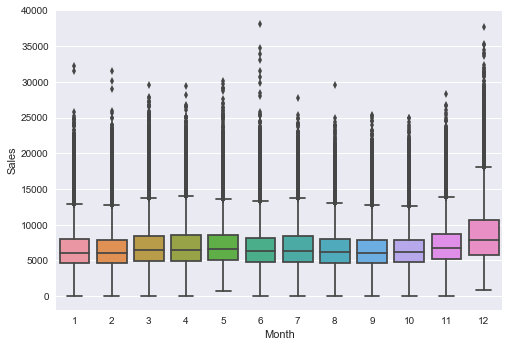

In [197]:
sns.boxplot(x=train_open['Month'], 
            y=train_open['Sales'])

Yep, December is clearly a different month. 